In [57]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification
import matplotlib.pyplot as plt

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
prod = 'B-PROD'

label2id = {'O':0, prod:1}
id2label = {0:'O', 1:prod}
MAX_LEN = 128

In [5]:
# model.load_state_dict()
path = "../data/saved_models/bert_trained.pth"
model = torch.load(path)
model.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [6]:
# load data
data_path = "../data/crawled_texts/"
datas = [os.path.join(data_path, fname) for fname in sorted(os.listdir(data_path))]
datas = [pd.read_json(fname, lines=True) for fname in datas]
data = pd.concat(datas)

In [7]:
data.text = data.text.str.strip()

In [36]:
def sperate_indices(indices_):
    product_indices = []
    if len(indices_) ==0:
        return product_indices
    start = indices_[0]
    indices_ = indices_.tolist()
    indices_.append(np.inf)
    prev = start
    if len(indices_)> 0:
        for ind in indices_[1:]:        
            if ind-prev > 1:
                product_indices.append([start, prev])
                start = ind
            prev = ind
    return product_indices

def get_products(sentence_):
#     print(sentence_)
    all_product_names =[]
#     for i in range(0, len(sentence_), 512):
#         sub_sentence = sentence_[i*512:(i+1)*512]
    inputs = tokenizer(sentence_, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")
    # move to gpu
    ids = inputs["input_ids"].to(device)
    mask = inputs["attention_mask"].to(device)
    # forward pass
    outputs = model(ids, mask)
    logits = outputs[0]
    active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
    flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level
    tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
    token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
    wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)
    word_level_predictions = []
    for pair in wp_preds:
        if (pair[0].startswith(" ##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
            # skip prediction
            continue
        else:
            word_level_predictions.append(pair[1])

    indices = np.where(np.array(token_predictions) == prod)[0]


    products_indices = sperate_indices(indices)
    product_names =[]
    for product_indices in products_indices:
        product_name = tokens[product_indices[0]:product_indices[1]+1]
        new_product_name = []
        for name in product_name:
            if name.startswith("##") and len(new_product_name) > 0:
                new_product_name[-1] += name.replace("##", '')
            else:
                new_product_name.append(name)
        new_product_name = " ".join([word for word in new_product_name \
                                 if not (word in ['[CLS]', '[SEP]', '[PAD]'])])
        product_names.append(new_product_name)
    all_product_names.extend(product_names)
    return all_product_names

In [46]:
sentences = data.text.apply(get_products)

In [47]:
sentences.to_csv('../data/results/predicted_results.csv')

# get the statistics of the all products

In [48]:
sentences.apply(len).sum()

458

In [49]:
# get the all products
all_prducts = np.concatenate(sentences.values.flatten())

In [50]:
unique, counts = np.unique(all_prducts, return_counts=True)

In [51]:
len(unique)

281

# most occured 5 objects

In [58]:
unique[counts.argsort()[-10:]].tolist()

['chairs',
 'bench',
 'gift',
 'stool',
 '##cks',
 'ham',
 'mirror',
 'table',
 'chair',
 'sofa']

<BarContainer object of 10 artists>

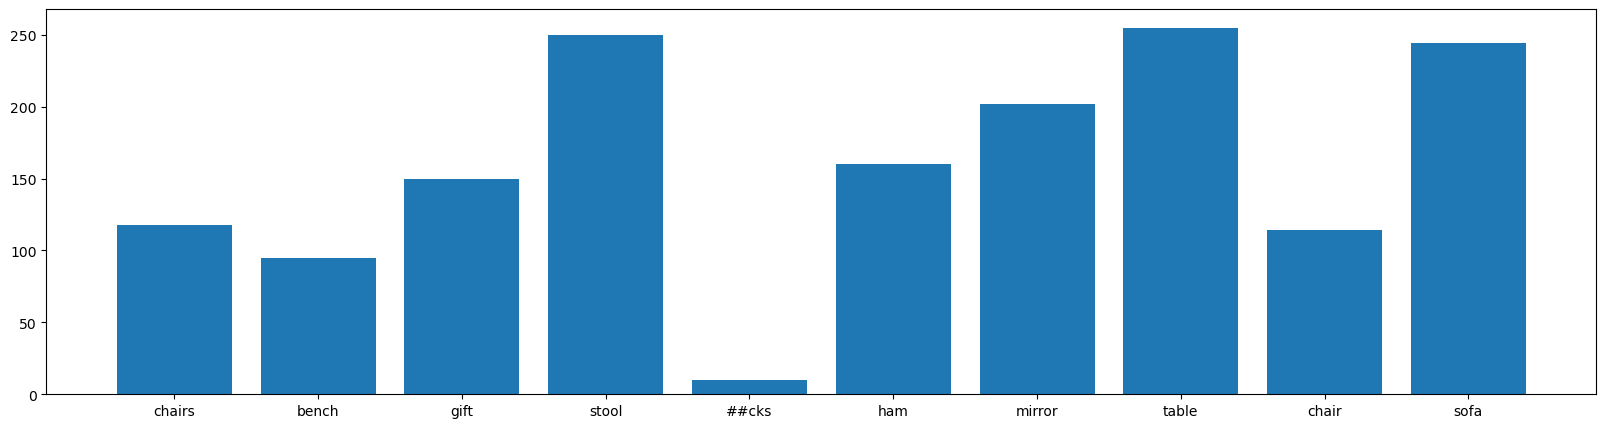

In [59]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(unique[counts.argsort()[-10:]].tolist(), counts.argsort()[-10:])